In [2]:
# Importing Libraries
import numpy as np
import pandas as pd
import re
import nltk
import pickle
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0
from tensorflow.keras.layers import Input, Dense, Embedding, GRU, Concatenate, Reshape
from tensorflow.keras import Model, Sequential


2023-12-15 17:07:25.635130: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-15 17:07:25.667037: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 17:07:25.667071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 17:07:25.668276: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 17:07:25.674279: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-15 17:07:25.675219: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
# Constants
AUTOTUNE = tf.data.experimental.AUTOTUNE 
vocab_size = 5000
sequence_length = 25
embedding_dim = 256
units = 512
batch_size = 64
epochs = 25
img_size = 224
channels = 3

# Directories
images = "Dataset/Images/"  # Updated path for your "Images" folder
captions = "Dataset/captions.txt"  # Updated path for your "captions.txt" file


In [4]:
# Read dataset, Drop null rows, Select only the first caption for each image
cap_df = pd.read_csv(captions, delimiter=",")
cap_df.columns = ["image_id", "caption"]  # Renaming columns if needed
cap_df.dropna(axis=0, inplace=True)

# Select only the first caption for each image
cap_df = cap_df.groupby("image_id").first().reset_index()

cap_df.sample(5)


,image_id,caption
5871,3482859574_3908de3427.jpg,A group of girls wearing costumes stand in a p...
4627,3231575742_31732664cf.jpg,"A kid cross-country skis wearing the number "" ..."
3051,2832978253_8fcc72da3b.jpg,A hiker climbing a rocky hill with fog surroun...
3606,2990471798_73c50c76fb.jpg,A boy jumps through the air onto something red .
2034,2477623312_58e8e8c8af.jpg,A child in winter gear is posing while a crowd...


In [5]:
# Take only one caption for every image
df = cap_df.groupby("image_id").first().reset_index()  # Assuming you have already selected the first caption
df = pd.DataFrame(df)
df.sample(5)


,image_id,caption
5366,3381392182_db2c42430e.jpg,A man dressed in a funny outfit dancing around .
542,1489286545_8df476fa26.jpg,A man and a dog sit on a bench near a body of ...
1474,229951087_4c20600c32.jpg,A man paddles a canoe in a lake .
7701,539801139_7258ee437f.jpg,A little boy playing in the water while its ra...
6632,3636126441_5617c89aaa.jpg,A boy flipping off a skateboard going down a f...


A boy flipping off a skateboard going down a flight of stairs 



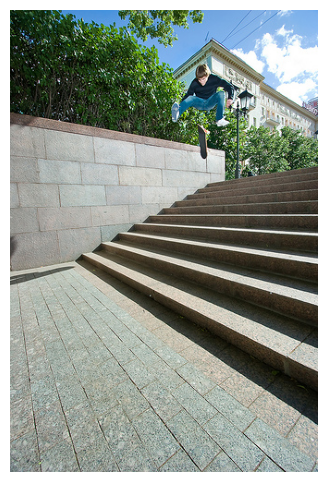

In [18]:
image_path = "3636126441_5617c89aaa.jpg"  # Change this to the desired image filename
selected_row = df[df["image_id"].str.contains(image_path)]

# Show image
plt.figure(figsize=(6, 6))
img = plt.imread("Dataset/Images/" + image_path)  # Adjusted image path
plt.axis("off")
plt.imshow(img)

# Print the caption for the selected image
if not selected_row.empty:
    print(selected_row["caption"].iloc[0], "\n")
else:
    print("Image not found in the dataset.")


In [23]:
# Download NLTK resources (uncomment the following lines if needed)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import nltk
from nltk.stem import WordNetLemmatizer
import re
# Assuming you have already imported necessary libraries and modules

# Clean Text
lemmatizer = WordNetLemmatizer()
def clean_text(sent):
    sent = sent.lower()
    sent = re.sub("[0-9]", "", sent)  # digits
    sent = re.sub("https?://\S+", "", sent)  # URLs
    sent = re.sub("@\S+", "", sent)  # @'s
    sent = re.sub("[+-/*,':%$#&!_<>(){}^]", "", sent)  # special characters
    sent = re.sub(" +", " ", sent)  # extra spaces
    words = nltk.word_tokenize(sent)
    stop_words = set(nltk.corpus.stopwords.words("english"))
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    sent = '[start] ' + ' '.join(words) + ' [end]'  # Adjusted the format
    return sent

df["caption"] = df["caption"].apply(lambda x: clean_text(x))


[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Assuming you have already imported necessary libraries and modules

# Create Sentence Vectorizer
sent_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length
)
sent_vectorization.adapt(df["caption"].values)

# Index to Word mapping
index_to_word = dict(enumerate(sent_vectorization.get_vocabulary()))


In [25]:
# Assuming you have already imported necessary libraries and modules

def image_read(path):
    path = "Dataset/Images/" + path  # Adjusted path based on your directory structure
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=channels)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, (img_size, img_size))
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img

def process_text(sentences):
    caption_vector = sent_vectorization(sentences)
    return caption_vector

def create_dataset(images, texts, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((images, texts))
    dataset = dataset.map(lambda a, b: (image_read(a), process_text(b)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset


In [26]:
# Assuming you have already imported necessary libraries and modules

df = df.sample(frac=1)
trn = df[:30783]
test = df[30783:]

train = create_dataset(trn["image_id"].values, trn["caption"].values, batch_size)


In [27]:
# Assuming you have already imported necessary libraries and modules

# EfficientNet for image context
base_model = EfficientNetV2B0(input_shape=(img_size, img_size, 3), include_top=False, weights="imagenet")  # Updated to EfficientNetV2B0
base_model.trainable = False
base_model_out = base_model.output
base_model_out = tf.keras.layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
cnn_model = Model(base_model.input, base_model_out)

# CNN_encoder for fine-tuning
class CNN_encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_encoder, self).__init__()
        self.dense = Dense(embedding_dim, activation="relu")
        
    def call(self, img_context):
        x = self.dense(img_context)
        return x


In [28]:
# Assuming you have already imported necessary libraries and modules

# Attention Class
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.units = units
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.S = Dense(1)
    
    def call(self, features, hidden):
        hidden_state_with_time_axis = tf.expand_dims(hidden, 1)
        
        attention_hidden_layer = tf.nn.tanh(self.W1(features) + 
                                            self.W2(hidden_state_with_time_axis))
        
        score = self.S(attention_hidden_layer)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        context_vector = features * attention_weights
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector


In [29]:
# Assuming you have already imported necessary libraries and modules

# RNN_decoder for sentence creation
class RNN_decoder(tf.keras.Model):
    def __init__(self, embedding_size, vocab_size, units):
        super(RNN_decoder, self).__init__()
        self.units = units
        self.attention = Attention(units)
        self.embedding = Embedding(vocab_size, embedding_size)
        self.gru = GRU(units, 
                       return_sequences=True, 
                       return_state=True)
        self.dense1 = Dense(units)
        self.dense2 = Dense(vocab_size)
    
    def call(self, x, features, hidden_state):
        context_vector = self.attention(features, hidden_state)
        x = self.embedding(x)
        x = tf.concat([x, tf.expand_dims(context_vector, 1)], axis=-1)
        x, states = self.gru(x)
        x = self.dense1(x)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.dense2(x)
        return x, states


In [30]:
# Assuming you have already imported necessary libraries and modules

encoder = CNN_encoder(embedding_dim)
decoder = RNN_decoder(embedding_dim, vocab_size, units)

optimizer = tf.keras.optimizers.Adam()
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Custom loss function 
# Ignores the prediction of [mask] values
def loss_fn(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    final_loss = loss_obj(real, pred)
    
    mask = tf.cast(mask, dtype=final_loss.dtype)
    final_loss *= mask
    
    return tf.reduce_sum(final_loss)


In [31]:
# Assuming you have already imported necessary libraries and modules

# For each Batch
def train_step(img_tensor, target):
    loss = 0
    dec_input = tf.expand_dims([int(sent_vectorization('[start]')[0])] * target.shape[0], 1)
    hidden_state = tf.zeros((batch_size, units))
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        
        for i in range(1, target.shape[1]):
            pred, hidden_state = decoder(dec_input, features, hidden_state)
            loss += loss_fn(target[:, i], pred)
            
            dec_input = tf.expand_dims(target[:, i], 1)
        
    total_loss = loss / int(target.shape[1])
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))

    return total_loss


In [32]:
# Assuming you have already imported necessary libraries and modules

# Train model
for epoch in range(epochs):
    total_loss = 0
    
    for imgs, target in train:
        img_tensor = cnn_model(imgs)
        loss = train_step(img_tensor, target)
        total_loss += loss
    
    print("##### Epoch {} #####".format(epoch + 1))
    print("Loss is {}".format(total_loss / len(trn)), "\n")


2023-12-15 17:29:14.365344: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2023-12-15 17:29:14.681598: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2023-12-15 17:29:14.735382: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2023-12-15 17:29:14.748276: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2023-12-15 17:29:14.798895: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.


##### Epoch 1 #####
Loss is 1.4471538066864014 

##### Epoch 2 #####
Loss is 1.142944097518921 

##### Epoch 3 #####
Loss is 1.0163170099258423 

##### Epoch 4 #####
Loss is 0.918757438659668 

##### Epoch 5 #####
Loss is 0.8344890475273132 

##### Epoch 6 #####
Loss is 0.7665372490882874 



In [ ]:
# Assuming you have already imported necessary libraries and modules

# Save weights of Model and Vectorizer
encoder.save_weights("encoder_weights.h5")
decoder.save_weights("decoder_weights.h5")

sent_vectorization_config = sent_vectorization.get_config()
sent_vectorization_weights = sent_vectorization.get_weights()

with open("sent_vectorizer.pkl", "wb") as f:
    pickle.dump({'config': sent_vectorization_config, 'weights': sent_vectorization_weights}, f)


In [ ]:
# Assuming you have already imported necessary libraries and modules

# Caption function for evaluation
def caption(path):
    img = image_read(path)
    img = tf.expand_dims(img, 0)
    context = cnn_model(img)
    features = encoder(context)
    
    dec_input = tf.expand_dims([int(sent_vectorization('[start]')[0])], 0)
    hidden_state = tf.zeros((1, units))
    sentence = []
    for i in range(20):
        pred, hidden_state = decoder(dec_input, features, hidden_state)
        predicted_id = np.argmax(tf.reshape(pred, -1))
        predicted_word = index_to_word[predicted_id]
        sentence.append(predicted_word)
    
        if predicted_word == "end":
            return ' '.join(sentence[:-1])
        
        dec_input = tf.expand_dims([predicted_id], 0)
    return ' '.join(sentence)


In [ ]:
# Show image
plt.figure(figsize=(6, 6))
img_path = "Dataset/Images/" + test["image_id"].iloc[5]  # Adjusted image path
img = plt.imread(img_path)
plt.axis("off")
plt.imshow(img)

# Generate and print the caption
pred = caption(img_path)
print(pred, "\n")


In [ ]:
# Assuming you have already imported necessary libraries and modules

# BLEU score function
def BLEU_score(real, pred):
    x = real.split()
    y = pred.split()
    
    smooth = SmoothingFunction().method4
    bleu = sentence_bleu([x[1:-1]], y, smoothing_function=smooth)
    return bleu


In [ ]:
# Evaluate on Test Data
# BLEU score the Higher the Better
bleu = 0
for i in range(test.shape[0]):
    test_img = test["image_id"].iloc[i]  # Use index i to iterate over all rows
    test_target = test["comment"].iloc[i]
    prediction = caption(test_img)
    bleu += BLEU_score(test_target, prediction)

print("BLEU score is {}".format(bleu / test.shape[0]))
